In [1]:
import pandas as pd

In [ ]:
data = pd.read_csv('data/human_written_comments_reddit.csv', encoding='utf-8')
data.head()

# ...

,post_id,post_title,post_text,comment
0,ivq7a5,We need updated consumer protection,There are so many issues floating around that ...,I find that the best solution to this problem ...
1,hg7165,Does modern technology make us dumber?,Hi. A lot has changed since the agrarian and i...,Not to mention that increased use of social me...
2,hg7165,Does modern technology make us dumber?,Hi. A lot has changed since the agrarian and i...,"I don't think it makes us dumber, but it certa..."
3,hg7165,Does modern technology make us dumber?,Hi. A lot has changed since the agrarian and i...,"Short answer, yes.\n\nLonger answer, it depend..."
4,hg7165,Does modern technology make us dumber?,Hi. A lot has changed since the agrarian and i...,"Well.. SOME people CHOOSE to no longer ""think ..."


#### use one cell for each metric for clear and easy to follow code
##### - do not assume or rely on pkl files in your code - generate everything from scratch
##### - in case the computation is time consuming, write that in a comment at the beginning of your implementation
##### - document your code with comments - both markdown and inline

### DATA LOADING

In [13]:
# Load all CSV files
import os

data_dir = 'data/'
files = {
    'human': 'human_written_comments_reddit.csv',
    'claude': 'generated_comments_claude-sonnet-4-0_temp_0.7.csv',
    'gpt4': 'generated_comments_gpt4.1Mini-instruct_temp-0.7.csv',
    'llama': 'generated_comments_llama-3-3-70b-instruct_temp-0.7.csv',
    'qwen': 'generated_comments_Qwen2.5-72B-Instruct_temp-0.7.csv'
}

# Load all dataframes
dfs = {}
for name, filename in files.items():
    filepath = os.path.join(data_dir, filename)
    dfs[name] = pd.read_csv(filepath, encoding='utf-8')
    print(f"\n{'-'*30}")
    print(f"Loaded: {name.upper()} - {filename}")
    print(f"{'-'*30}")



------------------------------
Loaded: HUMAN - human_written_comments_reddit.csv
------------------------------

------------------------------
Loaded: CLAUDE - generated_comments_claude-sonnet-4-0_temp_0.7.csv
------------------------------

------------------------------
Loaded: GPT4 - generated_comments_gpt4.1Mini-instruct_temp-0.7.csv
------------------------------

------------------------------
Loaded: LLAMA - generated_comments_llama-3-3-70b-instruct_temp-0.7.csv
------------------------------

------------------------------
Loaded: QWEN - generated_comments_Qwen2.5-72B-Instruct_temp-0.7.csv
------------------------------


### DATA EXPLORATION

In [14]:
# Check the structure of each dataset
print("DATASET STRUCTURES")
print("="*80)

dfs_cleaned = {}

for name, df in dfs.items():
    print(f"\n{name.upper()}:")
    print(f"  Shape: {df.shape}")
    print(f"  Missing values:\n{df.isnull().sum()}")

    original_len = len(df)
    # Remove rows where any value is missing
    df_cleaned = df.dropna()
    removed = original_len - len(df_cleaned)
    dfs_cleaned[name] = df_cleaned
    if removed > 0:
        print(f"\n{name.upper()}:")
        print(f"  Original rows: {original_len}")
        print(f"  Rows removed: {removed} ({removed/original_len*100:.2f}%)")
        print(f"  Remaining rows: {len(df_cleaned)}")

# Replace the original dfs dictionary with cleaned version
dfs = dfs_cleaned


DATASET STRUCTURES

HUMAN:
  Shape: (11678, 4)
  Missing values:
post_id         0
post_title      0
post_text     253
comment         0
dtype: int64

HUMAN:
  Original rows: 11678
  Rows removed: 253 (2.17%)
  Remaining rows: 11425

CLAUDE:
  Shape: (8813, 4)
  Missing values:
post_id         0
post_title      0
post_text     227
comment         0
dtype: int64

CLAUDE:
  Original rows: 8813
  Rows removed: 227 (2.58%)
  Remaining rows: 8586

GPT4:
  Shape: (7429, 4)
  Missing values:
post_id        23
post_title     26
post_text     221
comment        34
dtype: int64

GPT4:
  Original rows: 7429
  Rows removed: 229 (3.08%)
  Remaining rows: 7200

LLAMA:
  Shape: (16186, 4)
  Missing values:
post_id       0
post_title    0
post_text     0
comment       0
dtype: int64

QWEN:
  Shape: (10208, 4)
  Missing values:
post_id       0
post_title    0
post_text     0
comment       0
dtype: int64


In [18]:
# Analyze overlap of post_id between the datasets
print("POST_ID OVERLAP ANALYSIS")
print("="*80)

# Extract unique post IDs from each dataset
post_id_sets = {}
for name, df in dfs.items():
    post_id_sets[name] = set(df['post_id'].unique())
    print(f"\n{name.upper()}: {len(post_id_sets[name])} unique post IDs")

# Calculate overlaps
print("\n" + "="*80)
print("OVERLAP SUMMARY")

# All datasets intersection (posts in ALL datasets)
all_posts_intersection = set.intersection(*post_id_sets.values())
print(f"\nPost IDs appearing in ALL {len(post_id_sets)} datasets: {len(all_posts_intersection)}")

# All datasets union (all unique posts across all datasets)
all_posts_union = set.union(*post_id_sets.values())
print(f"Total unique post IDs across ALL datasets: {len(all_posts_union)}")


POST_ID OVERLAP ANALYSIS

HUMAN: 4735 unique post IDs

CLAUDE: 3312 unique post IDs

GPT4: 3583 unique post IDs

LLAMA: 2035 unique post IDs

QWEN: 1613 unique post IDs

OVERLAP SUMMARY

Post IDs appearing in ALL 5 datasets: 309
Total unique post IDs across ALL datasets: 5314


In [19]:
# Find posts that appear in ALL datasets and compare comments
print("COMPARING COMMENTS FOR POSTS APPEARING IN ALL DATASETS")
print("="*80)

# Find post IDs that appear in all datasets
post_id_sets = {name: set(df['post_id'].unique()) for name, df in dfs.items()}
common_post_ids = set.intersection(*post_id_sets.values())

print(f"\nFound {len(common_post_ids)} posts that appear in ALL datasets")

# Select 3 random posts from the common ones
import random
random.seed(42)
selected_post_ids = random.sample(list(common_post_ids), min(3, len(common_post_ids)))

print(f"Analyzing {len(selected_post_ids)} posts...\n")

# For each selected post, show the post details and all comments
for post_num, post_id in enumerate(selected_post_ids, 1):
    print("\n" + "="*80)
    print(f"POST {post_num} - ID: {post_id}")
    print("="*80)
    
    # Get post details from the first dataset (should be same across all)
    first_df = list(dfs.values())[0]
    post_row = first_df[first_df['post_id'] == post_id].iloc[0]
    
    print(f"\nTITLE: {post_row['post_title']}")
    print(f"\nTEXT:")
    post_text = post_row['post_text']
    # Print post text with word wrap for readability
    if len(str(post_text)) > 500:
        print(f"{post_text[:500]}...")
        print(f"[Text truncated, full length: {len(str(post_text))} characters]")
    else:
        print(post_text)
    
    print("\n" + "-"*80)
    print("COMMENTS FROM EACH DATASET:")
    print("-"*80)
    
    # Show comments from each dataset for this post
    for name, df in dfs.items():
        post_comments = df[df['post_id'] == post_id]['comment']
        
        print(f"\n{'*'*80}")
        print(f"* {name.upper()} ({len(post_comments)} comment(s))")
        print(f"{'*'*80}")
        
        if len(post_comments) > 0:
            # Show up to 3 comments from this dataset for this post
            for idx, comment in enumerate(post_comments.head(3), 1):
                print(f"\nComment {idx}:")
                if len(str(comment)) > 400:
                    print(f"{comment[:400]}...")
                    print(f"[Truncated, full length: {len(str(comment))} characters]")
                else:
                    print(comment)
                
            if len(post_comments) > 3:
                print(f"\n[... and {len(post_comments) - 3} more comment(s)]")
        else:
            print("No comments found for this post")

print("\n" + "="*80)
print("END OF COMMENT COMPARISON")
print("="*80)


COMPARING COMMENTS FOR POSTS APPEARING IN ALL DATASETS

Found 309 posts that appear in ALL datasets
Analyzing 3 posts...


POST 1 - ID: 1gp2d8u

TITLE: Now What 

TEXT:
Ok so, I've simplified my life. 

Now, I have so much free time. It's kind crazy. I work 25-30 hours a week, nights. So I have every day completely open. No kids, no pets, and - I live in my van. 

I'm working with my therapist on ADHD stuff and wondering if this is contributing to my issue. I don't have a ton of motivation to do anything/can't find much that piques my interest enough to pursue it. 

What do you do with all of your free time and do you ever feel like you have too much time on yo...
[Text truncated, full length: 665 characters]

--------------------------------------------------------------------------------
COMMENTS FROM EACH DATASET:
--------------------------------------------------------------------------------

********************************************************************************
* HUMAN 

In [21]:
# Basic statistics for each dataset
print("\nBASIC STATISTICS")
print("="*80)

stats_data = []

for name, df in dfs.items():
    comment_cols = [col for col in df.columns if 'comment' in col.lower()]
    text_cols = [col for col in df.columns if 'text' in col.lower()]
    title_cols = [col for col in df.columns if 'title' in col.lower()]
    
    stats = {
        'Dataset': name,
    }
    
    # Comments statistics
    if comment_cols:
        comment_col = comment_cols[0]
        comments = df[comment_col].dropna()
        stats['Total Comments'] = len(comments)
        stats['Avg Comment Length'] = comments.astype(str).str.len().mean()
        stats['Median Comment Length'] = comments.astype(str).str.len().median()
        stats['Min Comment Length'] = comments.astype(str).str.len().min()
        stats['Max Comment Length'] = comments.astype(str).str.len().max()
    
    # Title statistics
    if title_cols:
        title_col = title_cols[0]
        titles = df[title_col].dropna()
        stats['Unique Titles/Posts'] = titles.nunique()
    
    # Text statistics (post text)
    if text_cols:
        text_col = text_cols[0]
        texts = df[text_col].dropna()
        stats['Avg Post Text Length'] = texts.astype(str).str.len().mean()
    
    stats_data.append(stats)

# Create summary DataFrame
stats_df = pd.DataFrame(stats_data)
print("\nSummary Statistics Table:")
print(stats_df.to_string(index=False))




BASIC STATISTICS

Summary Statistics Table:
Dataset  Total Comments  Avg Comment Length  Median Comment Length  Min Comment Length  Max Comment Length  Unique Titles/Posts  Avg Post Text Length
  human           11425          868.605339                  784.0                 458                4511                 4553           1038.225646
 claude            8586         1019.978803                 1011.0                 569                2009                 3198           1071.769276
   gpt4            7200          768.194167                  713.0                  10                1812                 3479           1098.794861
  llama           16186          933.934450                  897.0                 485                3955                 1964            838.929939
   qwen           10208          797.608444                  764.0                 476                2082                 1581            834.840419


### COMPARISON

In [27]:
# define comparison object
comparison_data = {
    'type': ['Human-Written', 'LLM (CLAUDE)', 'LLM (GPT4)', 'LLM (LLAMA)', 'LLM (QWEN)'],
}


In [ ]:
# Calculate mean sentence length for each dataset
import re

print("MEAN SENTENCE LENGTH ANALYSIS")
print("="*80)

# Function to split text into sentences
def split_into_sentences(text):
    """Split text into sentences using simple regex pattern"""
    if pd.isna(text) or text == '':
        return []
    # Split on common sentence endings: . ! ?
    # This handles basic cases like "Hello. World!" or "What? Really!"
    sentences = re.split(r'[.!?]+', str(text))
    # Filter out empty strings and strip whitespace
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

# Calculate sentence statistics for each dataset
sentence_stats = []

for name, df in dfs.items():
    
    comments = df['comment'].dropna()
    
    all_sentences = []
    sentence_counts = []
    
    for comment in comments:
        sentences = split_into_sentences(comment)
        all_sentences.extend(sentences)
        sentence_counts.append(len(sentences))
    
    # Calculate sentence lengths (in words)
    sentence_lengths = [len(sentence.split()) for sentence in all_sentences]
    
    stats = {
        'Dataset': name,
        'Total Comments': len(comments),
        'Total Sentences': len(all_sentences),
        'Avg Sentences per Comment': sum(sentence_counts) / len(sentence_counts) if sentence_counts else 0,
        'Avg Sentence Length (words)': sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0,
        'Median Sentence Length (words)': pd.Series(sentence_lengths).median() if sentence_lengths else 0,
        'Min Sentence Length (words)': min(sentence_lengths) if sentence_lengths else 0,
        'Max Sentence Length (words)': max(sentence_lengths) if sentence_lengths else 0,
    }
    
    sentence_stats.append(stats)

# Create summary DataFrame
print("\n" + "="*80)
print("SUMMARY: SENTENCE LENGTH STATISTICS")
print("="*80)

sentence_stats_df = pd.DataFrame(sentence_stats)
print("\n" + sentence_stats_df.to_string(index=False))

# Add metrics to comparison_data dictionary
print("\n" + "="*80)
print("Adding metrics to comparison_data dictionary...")
print("="*80)


# Initialize lists for the two new metrics
mean_sentence_lengths = []
sentences_per_comment = []

# Ensure the order matches the 'type' list order in comparison_data
# Order should be: human, claude, gpt4, llama, qwen
dataset_order = ['human', 'claude', 'gpt4', 'llama', 'qwen']

for dataset_name in dataset_order:
    # Find the stats for this dataset
    stats = next((s for s in sentence_stats if s['Dataset'] == dataset_name), None)
    if stats:
        mean_sentence_lengths.append(round(stats['Avg Sentence Length (words)'], 2))
        sentences_per_comment.append(round(stats['Avg Sentences per Comment'], 2))
    else:
        mean_sentence_lengths.append(0.0)
        sentences_per_comment.append(0.0)

# Add to comparison_data dictionary
comparison_data['Mean Sentence Length (words)'] = mean_sentence_lengths
comparison_data['Sentences per Comment'] = sentences_per_comment

print("\nMetrics added to comparison_data:")
print(f"  - Mean Sentence Length (words): {mean_sentence_lengths}")
print(f"  - Sentences per Comment: {sentences_per_comment}")

print("\n" + "="*80)

MEAN SENTENCE LENGTH ANALYSIS

SUMMARY: SENTENCE LENGTH STATISTICS

Dataset  Total Comments  Total Sentences  Avg Sentences per Comment  Avg Sentence Length (words)  Median Sentence Length (words)  Min Sentence Length (words)  Max Sentence Length (words)
  human           11425           109133                   9.552123                    16.364830                            14.0                            1                          281
 claude            8586            75081                   8.744584                    19.067487                            19.0                            1                           75
   gpt4            7200            48966                   6.800833                    18.606993                            19.0                            1                           70
  llama           16186            75115                   4.640739                    34.552579                            26.0                            1                          3

VISUALIZING SENTENCE LENGTH DISTRIBUTION


/var/folders/1b/6gj9w5sj0gjblcs02_x_1b6c0000gp/T/ipykernel_1001/2796763315.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(sentence_length_data, labels=dataset_names, patch_artist=True,


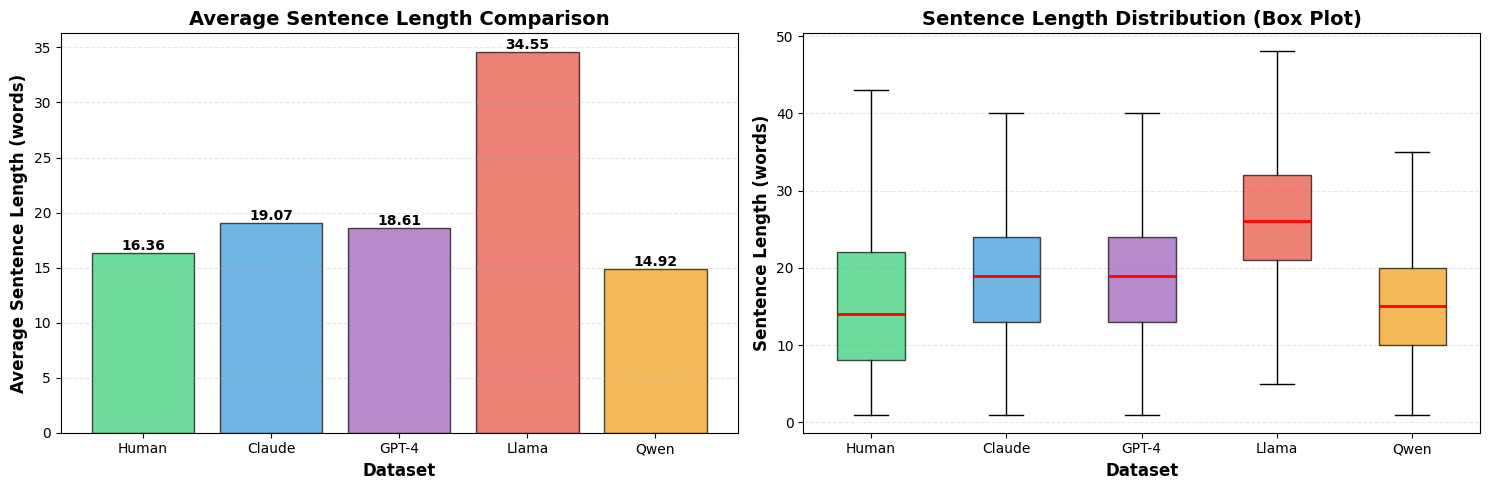


✓ Visualization complete!


In [29]:
# Visualize the distribution of Average Sentence Length per dataset
import matplotlib.pyplot as plt
import numpy as np

print("VISUALIZING SENTENCE LENGTH DISTRIBUTION")
print("="*80)

# Prepare data for visualization
dataset_names = ['Human', 'Claude', 'GPT-4', 'Llama', 'Qwen']
avg_sentence_lengths = [stats['Avg Sentence Length (words)'] for stats in sentence_stats]

# Create figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 1. Bar chart comparing average sentence lengths
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']
bars = ax1.bar(dataset_names, avg_sentence_lengths, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Sentence Length (words)', fontsize=12, fontweight='bold')
ax1.set_title('Average Sentence Length Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontweight='bold')

# 2. Box plot showing sentence length distribution (if we have detailed data)
# Calculate sentence lengths for each dataset
sentence_length_data = []
for name, df in dfs.items():
    comments = df['comment'].dropna()
    dataset_sentence_lengths = []
    
    for comment in comments:
        sentences = split_into_sentences(comment)
        for sentence in sentences:
            sentence_length = len(sentence.split())
            if sentence_length > 0:  # Filter out empty sentences
                dataset_sentence_lengths.append(sentence_length)
    
    sentence_length_data.append(dataset_sentence_lengths)

# Create box plot
bp = ax2.boxplot(sentence_length_data, labels=dataset_names, patch_artist=True,
                  showfliers=False, medianprops=dict(color='red', linewidth=2))

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sentence Length (words)', fontsize=12, fontweight='bold')
ax2.set_title('Sentence Length Distribution (Box Plot)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")
print("="*80)


### Sentence Length Distribution:
The box plots demonstrate that Human text exhibits the widest variance in sentence length, ranging from very short to moderately long sentences, whereas LLMs show more concentrated distributions around their respective medians

In [32]:
# Calculate type-to-token ratio for each dataset
print("TYPE-TO-TOKEN RATIO ANALYSIS")
print("="*80)
print("\nType-to-Token Ratio (TTR) = Number of unique words (types) / Total words (tokens)")
print("Higher TTR indicates more lexical diversity\n")

# Calculate TTR statistics for each dataset
ttr_stats = []

for name, df in dfs.items():
    
    comments = df['comment'].dropna()
    
    # Collect all tokens and types
    all_tokens = []
    
    for comment in comments:
        # Tokenize by splitting on whitespace and converting to lowercase
        tokens = str(comment).lower().split()
        all_tokens.extend(tokens)
    
    # Calculate types (unique tokens)
    unique_types = set(all_tokens)
    total_tokens = len(all_tokens)
    ttr = len(unique_types) / total_tokens if total_tokens > 0 else 0
    
    stats = {
        'Dataset': name,
        'Total Tokens': total_tokens,
        'Unique Types': len(unique_types),
        'Type-to-Token Ratio': ttr,
    }
    
    ttr_stats.append(stats)

# Create summary DataFrame
print("\n" + "="*80)
print("SUMMARY: TYPE-TO-TOKEN RATIO STATISTICS")
print("="*80)

ttr_stats_df = pd.DataFrame(ttr_stats)
print("\n" + ttr_stats_df.to_string(index=False))

# Add metrics to comparison_data dictionary
print("\n" + "="*80)
print("Adding TTR metric to comparison_data dictionary...")
print("="*80)

# Initialize list for TTR metric
type_to_token_ratios = []

# Ensure the order matches the 'type' list order in comparison_data
# Order should be: human, claude, gpt4, llama, qwen
dataset_order = ['human', 'claude', 'gpt4', 'llama', 'qwen']

for dataset_name in dataset_order:
    # Find the stats for this dataset
    stats = next((s for s in ttr_stats if s['Dataset'] == dataset_name), None)
    if stats:
        type_to_token_ratios.append(round(stats['Type-to-Token Ratio'], 4))
    else:
        type_to_token_ratios.append(0.0)

# Add to comparison_data dictionary
comparison_data['Type-to-Token Ratio'] = type_to_token_ratios

print("\nMetric added to comparison_data:")
print(f"  - Type-to-Token Ratio: {type_to_token_ratios}")

print("\n" + "="*80)

TYPE-TO-TOKEN RATIO ANALYSIS

Type-to-Token Ratio (TTR) = Number of unique words (types) / Total words (tokens)
Higher TTR indicates more lexical diversity


SUMMARY: TYPE-TO-TOKEN RATIO STATISTICS

Dataset  Total Tokens  Unique Types  Type-to-Token Ratio
  human       1777539        109128             0.061393
 claude       1429656         73370             0.051320
   gpt4        910185         58789             0.064590
  llama       2594671         48262             0.018600
   qwen       1417967         43199             0.030465

Adding TTR metric to comparison_data dictionary...

Metric added to comparison_data:
  - Type-to-Token Ratio: [0.0614, 0.0513, 0.0646, 0.0186, 0.0305]



### TTR Limitation
text length significantly affects the Type-to-Token Ratio (TTR) metric since the longer texts the Lower TTR.

As text gets longer, common words (like "the", "is", "and") inevitably repeat
The number of tokens grows faster than the number of unique types
TTR decreases, even if the text is actually quite diverse

Which means we cannot fairly compare TTR between datasets of different lengths

We'll try to calculate a few different metrics to get better understanding of that data aspect

### Three Approaches to Address Text Length Bias:
**Approach 1: Standardized TTR**
Method: Randomly samples exactly 50,000 tokens from each dataset

Advantage: Perfect fairness - all datasets compared on equal footing

Use case: When you want a completely unbiased comparison


In [39]:
# APPROACH 1: Standardized TTR (using equal-sized samples)
print("APPROACH 1: STANDARDIZED TTR (Equal Sample Size)")
print("="*80)
print("Calculate TTR on equal-sized token samples to enable fair comparison\n")

# Find a reasonable sample size (use 80% of the smallest dataset's tokens)
# or set a fixed size like 100,000 tokens
import random
random.seed(42)

# Let's use 50,000 tokens as standard sample size
SAMPLE_SIZE = 50000

standardized_ttr_stats = []

for name, df in dfs.items():
    print(f"\nProcessing {name.upper()}...")
    
    comments = df['comment'].dropna()
    
    # Collect all tokens
    all_tokens = []
    for comment in comments:
        tokens = str(comment).lower().split()
        all_tokens.extend(tokens)
    
    print(f"  Total available tokens: {len(all_tokens):,}")
    
    # If we have fewer tokens than sample size, use all available
    if len(all_tokens) < SAMPLE_SIZE:
        sampled_tokens = all_tokens
        print(f"  WARNING: Using all {len(all_tokens):,} tokens (less than {SAMPLE_SIZE:,})")
    else:
        # Randomly sample SAMPLE_SIZE tokens
        sampled_tokens = random.sample(all_tokens, SAMPLE_SIZE)
        print(f"  Sampled: {SAMPLE_SIZE:,} tokens")
    
    # Calculate TTR on the sample
    unique_types = set(sampled_tokens)
    ttr = len(unique_types) / len(sampled_tokens) if len(sampled_tokens) > 0 else 0
    
    stats = {
        'Dataset': name,
        'Sample Size (tokens)': len(sampled_tokens),
        'Unique Types': len(unique_types),
        'Standardized TTR': ttr,
    }
    
    standardized_ttr_stats.append(stats)
    

# Create summary DataFrame
print("\n" + "="*80)
print("SUMMARY: STANDARDIZED TTR STATISTICS")
print("="*80)

standardized_ttr_df = pd.DataFrame(standardized_ttr_stats)
print("\n" + standardized_ttr_df.to_string(index=False))

# Add to comparison_data
standardized_ttr_values = []
dataset_order = ['human', 'claude', 'gpt4', 'llama', 'qwen']

for dataset_name in dataset_order:
    stats = next((s for s in standardized_ttr_stats if s['Dataset'] == dataset_name), None)
    if stats:
        standardized_ttr_values.append(round(stats['Standardized TTR'], 4))
    else:
        standardized_ttr_values.append(0.0)

comparison_data['Standardized TTR'] = standardized_ttr_values

print("\n✓ Added Standardized TTR to comparison_data")
print(f"  Values: {standardized_ttr_values}")
print("="*80)


APPROACH 1: STANDARDIZED TTR (Equal Sample Size)
Calculate TTR on equal-sized token samples to enable fair comparison


Processing HUMAN...
  Total available tokens: 1,777,539
  Sampled: 50,000 tokens

Processing CLAUDE...
  Total available tokens: 1,429,656
  Sampled: 50,000 tokens

Processing GPT4...
  Total available tokens: 910,185
  Sampled: 50,000 tokens

Processing LLAMA...
  Total available tokens: 2,594,671
  Sampled: 50,000 tokens

Processing QWEN...
  Total available tokens: 1,417,967
  Sampled: 50,000 tokens

SUMMARY: STANDARDIZED TTR STATISTICS

Dataset  Sample Size (tokens)  Unique Types  Standardized TTR
  human                 50000         10879           0.21758
 claude                 50000         10920           0.21840
   gpt4                 50000         11022           0.22044
  llama                 50000          8119           0.16238
   qwen                 50000          9041           0.18082

✓ Added Standardized TTR to comparison_data
  Values: [0.2176,

### Approach 2: Root TTR
**Formula: Root TTR = Unique Types / √(Total Tokens)**

Method: Divides the number of unique words by the square root of total tokens

Advantage: Simple mathematical normalization that reduces length effects

Use case: Quick length-normalized comparison using all available data

In [41]:
# APPROACH 2: Root TTR (normalized by square root of tokens)
print("APPROACH 2: ROOT TTR (Length-Normalized)")
print("="*80)
print("Root TTR = Types / √(Tokens)")
print("This normalization helps account for text length differences\n")

root_ttr_stats = []

for name, df in dfs.items():
    
    comments = df['comment'].dropna()
    
    # Collect all tokens
    all_tokens = []
    for comment in comments:
        tokens = str(comment).lower().split()
        all_tokens.extend(tokens)
    
    # Calculate types (unique tokens)
    unique_types = set(all_tokens)
    total_tokens = len(all_tokens)
    
    # Calculate Root TTR
    root_ttr = len(unique_types) / (total_tokens ** 0.5) if total_tokens > 0 else 0
    
    # Also calculate regular TTR for comparison
    regular_ttr = len(unique_types) / total_tokens if total_tokens > 0 else 0
    
    stats = {
        'Dataset': name,
        'Total Tokens': total_tokens,
        'Unique Types': len(unique_types),
        'Regular TTR': regular_ttr,
        'Root TTR': root_ttr,
    }
    
    root_ttr_stats.append(stats)

# Create summary DataFrame
print("\n" + "="*80)
print("SUMMARY: ROOT TTR STATISTICS")
print("="*80)

root_ttr_df = pd.DataFrame(root_ttr_stats)
print("\n" + root_ttr_df.to_string(index=False))

# Add to comparison_data
root_ttr_values = []
dataset_order = ['human', 'claude', 'gpt4', 'llama', 'qwen']

for dataset_name in dataset_order:
    stats = next((s for s in root_ttr_stats if s['Dataset'] == dataset_name), None)
    if stats:
        root_ttr_values.append(round(stats['Root TTR'], 4))
    else:
        root_ttr_values.append(0.0)

comparison_data['Root TTR'] = root_ttr_values

print("\n✓ Added Root TTR to comparison_data")
print(f"  Values: {root_ttr_values}")
print("="*80)


APPROACH 2: ROOT TTR (Length-Normalized)
Root TTR = Types / √(Tokens)
This normalization helps account for text length differences


SUMMARY: ROOT TTR STATISTICS

Dataset  Total Tokens  Unique Types  Regular TTR  Root TTR
  human       1777539        109128     0.061393 81.851497
 claude       1429656         73370     0.051320 61.362457
   gpt4        910185         58789     0.064590 61.621354
  llama       2594671         48262     0.018600 29.961542
   qwen       1417967         43199     0.030465 36.277774

✓ Added Root TTR to comparison_data
  Values: [81.8515, 61.3625, 61.6214, 29.9615, 36.2778]


### Approach 3: MTLD (Measure of Textual Lexical Diversity)
**Method: Measures how many words the text can go through before TTR drops below 0.72**

Advantage: Most sophisticated; calculates in both directions and averages

Less sensitive to length: Designed specifically to be robust to text length variations

Use case: Most reliable for comparing texts of very different lengths

Note: May take a bit longer to compute

In [43]:

# APPROACH 3: MTLD (Measure of Textual Lexical Diversity)
print("APPROACH 3: MTLD (Measure of Textual Lexical Diversity)")
print("="*80)
print("MTLD measures how long text can go before losing lexical diversity")
print("Higher values indicate more consistent lexical diversity")
print("Less sensitive to text length than traditional TTR\n")

def calculate_mtld(tokens, threshold=0.72):
    """
    Calculate MTLD (Measure of Textual Lexical Diversity)
    
    Args:
        tokens: list of tokens (words)
        threshold: TTR threshold (default 0.72 as per McCarthy & Jarvis 2010)
    
    Returns:
        MTLD score
    """
    if len(tokens) < 10:
        return 0.0
    
    def mtld_forward(tokens):
        """Calculate MTLD moving forward through the text"""
        factor_count = 0
        types = set()
        token_count = 0
        
        for token in tokens:
            types.add(token)
            token_count += 1
            
            if token_count > 0:
                ttr = len(types) / token_count
                
                if ttr <= threshold:
                    factor_count += 1
                    types = set()
                    token_count = 0
        
        # Handle remaining tokens
        if token_count > 0:
            factor_count += (1 - (len(types) / token_count)) / (1 - threshold)
        
        return len(tokens) / factor_count if factor_count > 0 else len(tokens)
    
    # Calculate MTLD in both directions (forward and backward)
    mtld_fwd = mtld_forward(tokens)
    mtld_bwd = mtld_forward(tokens[::-1])
    
    # Return the average of both directions
    return (mtld_fwd + mtld_bwd) / 2

mtld_stats = []

for name, df in dfs.items():
    
    comments = df['comment'].dropna()
    
    # Collect all tokens
    all_tokens = []
    for comment in comments:
        tokens = str(comment).lower().split()
        all_tokens.extend(tokens)
    
    
    # Calculate MTLD
    mtld_score = calculate_mtld(all_tokens)
    
    stats = {
        'Dataset': name,
        'Total Tokens': len(all_tokens),
        'MTLD Score': mtld_score,
    }
    
    mtld_stats.append(stats)
    

# Create summary DataFrame
print("\n" + "="*80)
print("SUMMARY: MTLD STATISTICS")
print("="*80)

mtld_df = pd.DataFrame(mtld_stats)
print("\n" + mtld_df.to_string(index=False))

print("\nInterpretation:")
print("- Higher MTLD = more consistent lexical diversity throughout the text")
print("- MTLD typically ranges from 50-100+ for natural text")
print("- More robust to text length than traditional TTR")

# Add to comparison_data
mtld_values = []
dataset_order = ['human', 'claude', 'gpt4', 'llama', 'qwen']

for dataset_name in dataset_order:
    stats = next((s for s in mtld_stats if s['Dataset'] == dataset_name), None)
    if stats:
        mtld_values.append(round(stats['MTLD Score'], 2))
    else:
        mtld_values.append(0.0)

comparison_data['MTLD Score'] = mtld_values

print("\n✓ Added MTLD Score to comparison_data")
print(f"  Values: {mtld_values}")
print("="*80)

APPROACH 3: MTLD (Measure of Textual Lexical Diversity)
MTLD measures how long text can go before losing lexical diversity
Higher values indicate more consistent lexical diversity
Less sensitive to text length than traditional TTR


SUMMARY: MTLD STATISTICS

Dataset  Total Tokens  MTLD Score
  human       1777539  129.212204
 claude       1429656  214.940309
   gpt4        910185  200.635906
  llama       2594671   93.645589
   qwen       1417967  116.893269

Interpretation:
- Higher MTLD = more consistent lexical diversity throughout the text
- MTLD typically ranges from 50-100+ for natural text
- More robust to text length than traditional TTR

✓ Added MTLD Score to comparison_data
  Values: [129.21, 214.94, 200.64, 93.65, 116.89]


### Mean Parse Tree Depth Analysis

Syntactic complexity through dependency parse tree depth

**Method:** 
- Uses spaCy to parse sentence structures
- Calculates depth from each word to the root of the parse tree
- Takes the maximum depth per sentence and averages across all sentences
- Samples 500 comments per dataset for computational efficiency

**Interpretation:**
- **Depth 3-5:** Simple sentences
- **Depth 6-8:** Moderate complexity  
- **Depth 9+:** Complex, deeply nested structures

**Expected patterns:**
- Human comments: Mixed complexity with natural variation
- LLM comments: May show distinct syntactic patterns depending on the model

In [46]:
# Calculate mean parse tree depth for each dataset
# Note: This computation can be time-consuming for large datasets
print("MEAN PARSE TREE DEPTH ANALYSIS")
print("="*80)
print("Parse tree depth measures syntactic complexity")
print("Deeper trees = more complex sentence structures\n")

import spacy
from collections import deque

# Load spaCy model (using small model for speed, you can use 'en_core_web_md' for better accuracy)
print("Loading spaCy model...")
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("SpaCy model not found. Installing...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

print("✓ Model loaded\n")

def get_tree_depth(token):
    """
    Calculate the depth of a token in the parse tree
    """
    depth = 0
    while token.head != token:  # Until we reach the root
        depth += 1
        token = token.head
    return depth

def get_max_tree_depth(doc):
    """
    Get the maximum depth of the parse tree for a sentence
    """
    if len(doc) == 0:
        return 0
    return max([get_tree_depth(token) for token in doc])

# Calculate parse tree depth statistics
parse_depth_stats = []

# Sample size for computational efficiency (you can increase this)
SAMPLE_COMMENTS = 500  # Sample 500 comments from each dataset

for name, df in dfs.items():
    print(f"\nProcessing {name.upper()}...")
    
    comments = df['comment'].dropna()
    
    # Sample comments if dataset is large
    if len(comments) > SAMPLE_COMMENTS:
        sampled_comments = comments.sample(SAMPLE_COMMENTS, random_state=42)
        print(f"  Sampling {SAMPLE_COMMENTS} comments from {len(comments)}")
    else:
        sampled_comments = comments
        print(f"  Using all {len(comments)} comments")
    
    all_depths = []
    sentence_count = 0
    
    # Process each comment
    for idx, comment in enumerate(sampled_comments):
        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{len(sampled_comments)} comments...")
        
        # Parse the comment
        doc = nlp(str(comment)[:1000000])  # Limit to 1M chars to avoid memory issues
        
        # Get depth for each sentence in the comment
        for sent in doc.sents:
            if len(sent) > 0:
                depth = get_max_tree_depth(sent)
                all_depths.append(depth)
                sentence_count += 1
    
    # Calculate statistics
    if all_depths:
        mean_depth = sum(all_depths) / len(all_depths)
        median_depth = sorted(all_depths)[len(all_depths) // 2]
        max_depth = max(all_depths)
        min_depth = min(all_depths)
    else:
        mean_depth = median_depth = max_depth = min_depth = 0
    
    stats = {
        'Dataset': name,
        'Comments Analyzed': len(sampled_comments),
        'Total Sentences': sentence_count,
        'Mean Parse Depth': mean_depth,
        'Median Parse Depth': median_depth,
        'Min Parse Depth': min_depth,
        'Max Parse Depth': max_depth,
    }
    
    parse_depth_stats.append(stats)
    
    print(f"  Sentences analyzed: {sentence_count}")
    print(f"  Mean parse tree depth: {mean_depth:.2f}")
    print(f"  Median parse tree depth: {median_depth}")

# Create summary DataFrame
print("\n" + "="*80)
print("SUMMARY: PARSE TREE DEPTH STATISTICS")
print("="*80)

parse_depth_df = pd.DataFrame(parse_depth_stats)
print("\n" + parse_depth_df.to_string(index=False))

print("\nInterpretation:")
print("- Higher depth = more complex syntactic structures")
print("- Human writing often shows more variation in depth")
print("- LLMs may show different patterns of syntactic complexity")

# Add to comparison_data
mean_parse_depths = []
dataset_order = ['human', 'claude', 'gpt4', 'llama', 'qwen']

for dataset_name in dataset_order:
    stats = next((s for s in parse_depth_stats if s['Dataset'] == dataset_name), None)
    if stats:
        mean_parse_depths.append(round(stats['Mean Parse Depth'], 2))
    else:
        mean_parse_depths.append(0.0)

comparison_data['Mean Parse Depth'] = mean_parse_depths

print("\n✓ Added Mean Parse Depth to comparison_data")
print(f"  Values: {mean_parse_depths}")
print("="*80)

MEAN PARSE TREE DEPTH ANALYSIS
Parse tree depth measures syntactic complexity
Deeper trees = more complex sentence structures

Loading spaCy model...
✓ Model loaded


Processing HUMAN...
  Sampling 500 comments from 11425
  Processed 100/500 comments...
  Processed 200/500 comments...
  Processed 300/500 comments...
  Processed 400/500 comments...
  Processed 500/500 comments...
  Sentences analyzed: 4663
  Mean parse tree depth: 4.72
  Median parse tree depth: 4

Processing CLAUDE...
  Sampling 500 comments from 8586
  Processed 100/500 comments...
  Processed 200/500 comments...
  Processed 300/500 comments...
  Processed 400/500 comments...
  Processed 500/500 comments...
  Sentences analyzed: 4431
  Mean parse tree depth: 5.33
  Median parse tree depth: 5

Processing GPT4...
  Sampling 500 comments from 7200
  Processed 100/500 comments...
  Processed 200/500 comments...
  Processed 300/500 comments...
  Processed 400/500 comments...
  Processed 500/500 comments...
  Sentences anal

### Additional Linguistic Measurements

**Motivation:** Capture complementary stylistic and structural patterns that distinguish human from LLM writing.

**Metrics implemented:**

1. **Average Word Length**
   - Measures vocabulary complexity and formality
   - LLMs may use more consistently formal vocabulary

2. **Burstiness (Sentence Variation)**
   - **Key metric**: Coefficient of variation in sentence length
   - Humans write with natural variation (short burst, then long sentence)
   - LLMs tend toward more uniform sentence lengths

3. **Punctuation Diversity**
   - Number of different punctuation marks used
   - Humans use varied punctuation (!, ?, ..., -, etc.)
   - Indicates expressive richness

4. **Contraction Rate**
   - **Very revealing**: Percentage of contractions (can't, won't, I'm)
   - High rate = conversational/informal (human-like)
   - Low rate = formal (some LLMs avoid contractions)

**Why these matter:** These metrics capture natural writing variation, informality, and expressiveness that humans exhibit but LLMs often lack.

In [49]:
# Additional Measurements for Human vs LLM Text Comparison
print("ADDITIONAL LINGUISTIC MEASUREMENTS")
print("="*80)
print("Implementing multiple metrics to capture different aspects of text generation\n")

import numpy as np
import string

additional_stats = []

for name, df in dfs.items():
    print(f"\nProcessing {name.upper()}...")
    
    comments = df['comment'].dropna()
    
    # Initialize collectors
    all_word_lengths = []
    all_sentence_lengths_chars = []
    all_sentence_lengths_words = []
    punctuation_counts = {p: 0 for p in string.punctuation}
    total_chars = 0
    unique_words_per_comment = []
    total_words = 0
    contraction_count = 0
    total_sentences = 0
    
    # Common contractions to detect
    contractions = ["n't", "'re", "'ve", "'ll", "'d", "'m", "'s"]
    
    for comment in comments:
        text = str(comment)
        total_chars += len(text)
        
        # Word analysis
        words = text.lower().split()
        total_words += len(words)
        
        # Word lengths
        word_lengths = [len(w.strip(string.punctuation)) for w in words if len(w.strip(string.punctuation)) > 0]
        all_word_lengths.extend(word_lengths)
        
        # Unique words per comment (local lexical diversity)
        unique_words_per_comment.append(len(set(words)) / len(words) if len(words) > 0 else 0)
        
        # Contraction detection
        for contraction in contractions:
            contraction_count += text.lower().count(contraction)
        
        # Sentence analysis
        sentences = split_into_sentences(text)
        total_sentences += len(sentences)
        
        for sent in sentences:
            all_sentence_lengths_chars.append(len(sent))
            all_sentence_lengths_words.append(len(sent.split()))
        
        # Punctuation analysis
        for char in text:
            if char in punctuation_counts:
                punctuation_counts[char] += 1
    
    # Calculate statistics
    
    # 1. Average word length
    avg_word_length = np.mean(all_word_lengths) if all_word_lengths else 0
    
    # 2. Burstiness (coefficient of variation in sentence length)
    # Higher burstiness = more variation (more human-like)
    if len(all_sentence_lengths_words) > 1:
        sent_length_std = np.std(all_sentence_lengths_words)
        sent_length_mean = np.mean(all_sentence_lengths_words)
        burstiness = sent_length_std / sent_length_mean if sent_length_mean > 0 else 0
    else:
        burstiness = 0
    
    # 3. Punctuation diversity (how many different punctuation marks used)
    punctuation_diversity = sum(1 for count in punctuation_counts.values() if count > 0)
    total_punctuation = sum(punctuation_counts.values())
    punctuation_density = total_punctuation / total_chars if total_chars > 0 else 0
    
    # 4. Average unique word ratio per comment
    avg_unique_ratio = np.mean(unique_words_per_comment) if unique_words_per_comment else 0
    
    # 5. Contraction rate
    contraction_rate = (contraction_count / total_words) * 100 if total_words > 0 else 0
    
    # 6. Character-level statistics
    avg_chars_per_comment = np.mean([len(str(c)) for c in comments])
    
    stats = {
        'Dataset': name,
        'Avg Word Length': avg_word_length,
        'Burstiness (Sentence Variation)': burstiness,
        'Punctuation Diversity': punctuation_diversity,
        'Punctuation Density (%)': punctuation_density * 100,
        'Avg Unique Words per Comment (%)': avg_unique_ratio * 100,
        'Contraction Rate (%)': contraction_rate,
        'Avg Characters per Comment': avg_chars_per_comment,
    }
    
    additional_stats.append(stats)
    
    print(f"  Avg word length: {avg_word_length:.2f} characters")
    print(f"  Burstiness: {burstiness:.3f} (higher = more varied)")
    print(f"  Punctuation diversity: {punctuation_diversity} different marks")
    print(f"  Contraction rate: {contraction_rate:.2f}%")

# Create summary DataFrame
print("\n" + "="*80)
print("SUMMARY: ADDITIONAL MEASUREMENTS")
print("="*80)

additional_stats_df = pd.DataFrame(additional_stats)
print("\n" + additional_stats_df.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION GUIDE")
print("="*80)
print("Avg Word Length: Longer words may indicate more formal/technical language")
print("Burstiness: Higher values = more variation (human writing is typically more bursty)")
print("Punctuation Diversity: More variety suggests richer expression")
print("Contraction Rate: Higher in informal/conversational text (more human-like)")
print("Unique Words per Comment: Local lexical diversity within individual comments")

# Add metrics to comparison_data
dataset_order = ['human', 'claude', 'gpt4', 'llama', 'qwen']

# Add each metric
metrics_to_add = {
    'Avg Word Length': 'Avg Word Length',
    'Burstiness': 'Burstiness (Sentence Variation)',
    'Punctuation Diversity': 'Punctuation Diversity',
    'Contraction Rate': 'Contraction Rate (%)',
}

for comp_key, stat_key in metrics_to_add.items():
    values = []
    for dataset_name in dataset_order:
        stats = next((s for s in additional_stats if s['Dataset'] == dataset_name), None)
        if stats:
            values.append(round(stats[stat_key], 2))
        else:
            values.append(0.0)
    comparison_data[comp_key] = values

print("\n✓ Added additional metrics to comparison_data")
print(f"  - Avg Word Length")
print(f"  - Burstiness")
print(f"  - Punctuation Diversity")
print(f"  - Contraction Rate")
print("="*80)

ADDITIONAL LINGUISTIC MEASUREMENTS
Implementing multiple metrics to capture different aspects of text generation


Processing HUMAN...
  Avg word length: 4.45 characters
  Burstiness: 0.752 (higher = more varied)
  Punctuation diversity: 32 different marks
  Contraction rate: 1.67%

Processing CLAUDE...
  Avg word length: 5.05 characters
  Burstiness: 0.436 (higher = more varied)
  Punctuation diversity: 31 different marks
  Contraction rate: 3.52%

Processing GPT4...
  Avg word length: 4.97 characters
  Burstiness: 0.419 (higher = more varied)
  Punctuation diversity: 32 different marks
  Contraction rate: 0.14%

Processing LLAMA...
  Avg word length: 4.73 characters
  Burstiness: 0.976 (higher = more varied)
  Punctuation diversity: 31 different marks
  Contraction rate: 4.07%

Processing QWEN...
  Avg word length: 4.63 characters
  Burstiness: 0.489 (higher = more varied)
  Punctuation diversity: 32 different marks
  Contraction rate: 1.41%

SUMMARY: ADDITIONAL MEASUREMENTS

Dataset

### Error and Mistake Detection

**Motivation:** LLMs produce "too perfect" text, lacking the natural imperfections of human writing. This **perfection paradox** makes AI-generated text detectable.

**What we measure:**
- **Typing errors**: Repeated words ("the the"), missing spaces, multiple spaces
- **Grammar slips**: Lowercase "i", capitalization mistakes  
- **Informal patterns**: ALL CAPS words, repeated punctuation (!!!, ???)
- **Total Error Score**: Combined metric normalized per 1,000 words

**Expected patterns:**
- **Human text**: Higher error rates (authentic mistakes from fast typing, emotion, informal style)
- **LLM text**: Lower error rates (overly clean, grammatically perfect output)

In [50]:
# Error and Mistake Detection - Human vs LLM Signature
print("ERROR AND MISTAKE ANALYSIS")
print("="*80)
print("Detecting common errors that are more prevalent in human writing\n")

import re

error_stats = []

for name, df in dfs.items():
    print(f"\nProcessing {name.upper()}...")
    
    comments = df['comment'].dropna()
    
    # Sample for computational efficiency (or use all if dataset is small)
    SAMPLE_SIZE = min(1000, len(comments))
    sampled_comments = comments.sample(SAMPLE_SIZE, random_state=42) if len(comments) > SAMPLE_SIZE else comments
    
    # Error counters
    total_words = 0
    repeated_words_count = 0  # "the the", "and and"
    multiple_spaces_count = 0  # Multiple consecutive spaces
    missing_space_after_punct = 0  # "word.word" or "word,word"
    lowercase_i_count = 0  # lowercase "i" instead of "I"
    repeated_punctuation = 0  # "!!!", "???"
    capitalization_errors = 0  # mid-sentence capitals
    all_caps_words = 0  # WORDS IN ALL CAPS
    typo_indicators = 0  # Common typo patterns
    
    for comment in sampled_comments:
        text = str(comment)
        words = text.split()
        total_words += len(words)
        
        # 1. Repeated words (the the)
        for i in range(len(words) - 1):
            if words[i].lower() == words[i+1].lower() and len(words[i]) > 2:
                repeated_words_count += 1
        
        # 2. Multiple consecutive spaces
        multiple_spaces_count += len(re.findall(r'  +', text))
        
        # 3. Missing space after punctuation
        missing_space_after_punct += len(re.findall(r'[.!?,;:][a-zA-Z]', text))
        
        # 4. Lowercase "i" when it should be capital
        # Check for " i " or "i'" patterns
        lowercase_i_count += len(re.findall(r'\si\s|\si\'', text))
        
        # 5. Repeated punctuation (!!!, ???, ...)
        repeated_punctuation += len(re.findall(r'[!?]{2,}', text))
        
        # 6. Random mid-sentence capitalization errors
        # Words that start with capital but aren't at sentence start
        sentences = re.split(r'[.!?]+', text)
        for sent in sentences:
            words_in_sent = sent.strip().split()
            if len(words_in_sent) > 1:
                # Check words after the first (skip proper nouns heuristically)
                for word in words_in_sent[1:]:
                    if word and word[0].isupper() and len(word) > 1:
                        # Simple heuristic: if it's not a common proper noun pattern
                        if not word.isupper() and not word[0].isdigit():
                            capitalization_errors += 1
        
        # 7. Words in ALL CAPS (shouting)
        for word in words:
            clean_word = word.strip(string.punctuation)
            if len(clean_word) > 2 and clean_word.isupper() and clean_word.isalpha():
                all_caps_words += 1
        
        # 8. Common typo patterns (doubled letters where uncommon)
        # Simple heuristic: three or more of the same letter
        typo_indicators += len(re.findall(r'([a-z])\1{2,}', text.lower()))
    
    # Calculate rates per 1000 words
    words_per_1000 = 1000
    
    stats = {
        'Dataset': name,
        'Comments Analyzed': len(sampled_comments),
        'Repeated Words (per 1K words)': (repeated_words_count / total_words * words_per_1000) if total_words > 0 else 0,
        'Multiple Spaces (per 1K words)': (multiple_spaces_count / total_words * words_per_1000) if total_words > 0 else 0,
        'Missing Space After Punct (per 1K)': (missing_space_after_punct / total_words * words_per_1000) if total_words > 0 else 0,
        'Lowercase "i" (per 1K words)': (lowercase_i_count / total_words * words_per_1000) if total_words > 0 else 0,
        'Repeated Punctuation (per 1K)': (repeated_punctuation / total_words * words_per_1000) if total_words > 0 else 0,
        'ALL CAPS Words (per 1K)': (all_caps_words / total_words * words_per_1000) if total_words > 0 else 0,
        'Total Error Score': (repeated_words_count + multiple_spaces_count + missing_space_after_punct + 
                             lowercase_i_count + all_caps_words) / total_words * words_per_1000 if total_words > 0 else 0
    }
    
    error_stats.append(stats)
    
    print(f"  Comments analyzed: {len(sampled_comments)}")
    print(f"  Repeated words: {stats['Repeated Words (per 1K words)']:.2f} per 1K words")
    # Use a variable to avoid backslash in f-string
    lowercase_i_key = 'Lowercase "i" (per 1K words)'
    print(f"  Lowercase 'i': {stats[lowercase_i_key]:.2f} per 1K words")
    print(f"  ALL CAPS words: {stats['ALL CAPS Words (per 1K)']:.2f} per 1K words")
    print(f"  Total error score: {stats['Total Error Score']:.2f}")

# Create summary DataFrame
print("\n" + "="*80)
print("SUMMARY: ERROR ANALYSIS")
print("="*80)

error_stats_df = pd.DataFrame(error_stats)
print("\n" + error_stats_df.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("Higher error rates typically indicate:")
print("  ✓ More human-like text (humans make typos and mistakes)")
print("  ✓ More informal/casual writing style")
print("  ✓ Less edited content")
print("\nLower error rates may indicate:")
print("  ✓ LLM-generated text (more 'perfect' output)")
print("  ✓ More formal/edited writing")
print("\nNote: 'ALL CAPS' and repeated punctuation can indicate emotion/emphasis in human text")

# Add total error score to comparison_data
dataset_order = ['human', 'claude', 'gpt4', 'llama', 'qwen']
error_scores = []

for dataset_name in dataset_order:
    stats = next((s for s in error_stats if s['Dataset'] == dataset_name), None)
    if stats:
        error_scores.append(round(stats['Total Error Score'], 2))
    else:
        error_scores.append(0.0)

comparison_data['Error Score (per 1K words)'] = error_scores

print("\n✓ Added Error Score to comparison_data")
print(f"  Values: {error_scores}")
print("="*80)


ERROR AND MISTAKE ANALYSIS
Detecting common errors that are more prevalent in human writing


Processing HUMAN...
  Comments analyzed: 1000
  Repeated words: 0.20 per 1K words
  Lowercase 'i': 1.58 per 1K words
  ALL CAPS words: 4.89 per 1K words
  Total error score: 16.80

Processing CLAUDE...
  Comments analyzed: 1000
  Repeated words: 0.01 per 1K words
  Lowercase 'i': 0.00 per 1K words
  ALL CAPS words: 3.79 per 1K words
  Total error score: 4.04

Processing GPT4...
  Comments analyzed: 1000
  Repeated words: 0.00 per 1K words
  Lowercase 'i': 0.00 per 1K words
  ALL CAPS words: 2.54 per 1K words
  Total error score: 2.77

Processing LLAMA...
  Comments analyzed: 1000
  Repeated words: 0.01 per 1K words
  Lowercase 'i': 0.01 per 1K words
  ALL CAPS words: 1.69 per 1K words
  Total error score: 1.93

Processing QWEN...
  Comments analyzed: 1000
  Repeated words: 0.00 per 1K words
  Lowercase 'i': 0.00 per 1K words
  ALL CAPS words: 1.62 per 1K words
  Total error score: 1.88

SUMMAR

# Results

#### report your results with a dataframe

In [53]:
final_results = pd.DataFrame(comparison_data)
print(final_results)

            type  Mean Sentence Length (words)  Sentences per Comment  \
0  Human-Written                         16.36                   9.55   
1   LLM (CLAUDE)                         19.07                   8.74   
2     LLM (GPT4)                         18.61                   6.80   
3    LLM (LLAMA)                         34.55                   4.64   
4     LLM (QWEN)                         14.92                   9.32   

   Type-to-Token Ratio  Standardized TTR  Root TTR  MTLD Score  \
0               0.0614            0.2176   81.8515      129.21   
1               0.0513            0.2184   61.3625      214.94   
2               0.0646            0.2204   61.6214      200.64   
3               0.0186            0.1624   29.9615       93.65   
4               0.0305            0.1808   36.2778      116.89   

   Mean Parse Depth  Avg Word Length  Burstiness  Punctuation Diversity  \
0              4.72             4.45        0.75                     32   
1             

### Visualizations Analysis


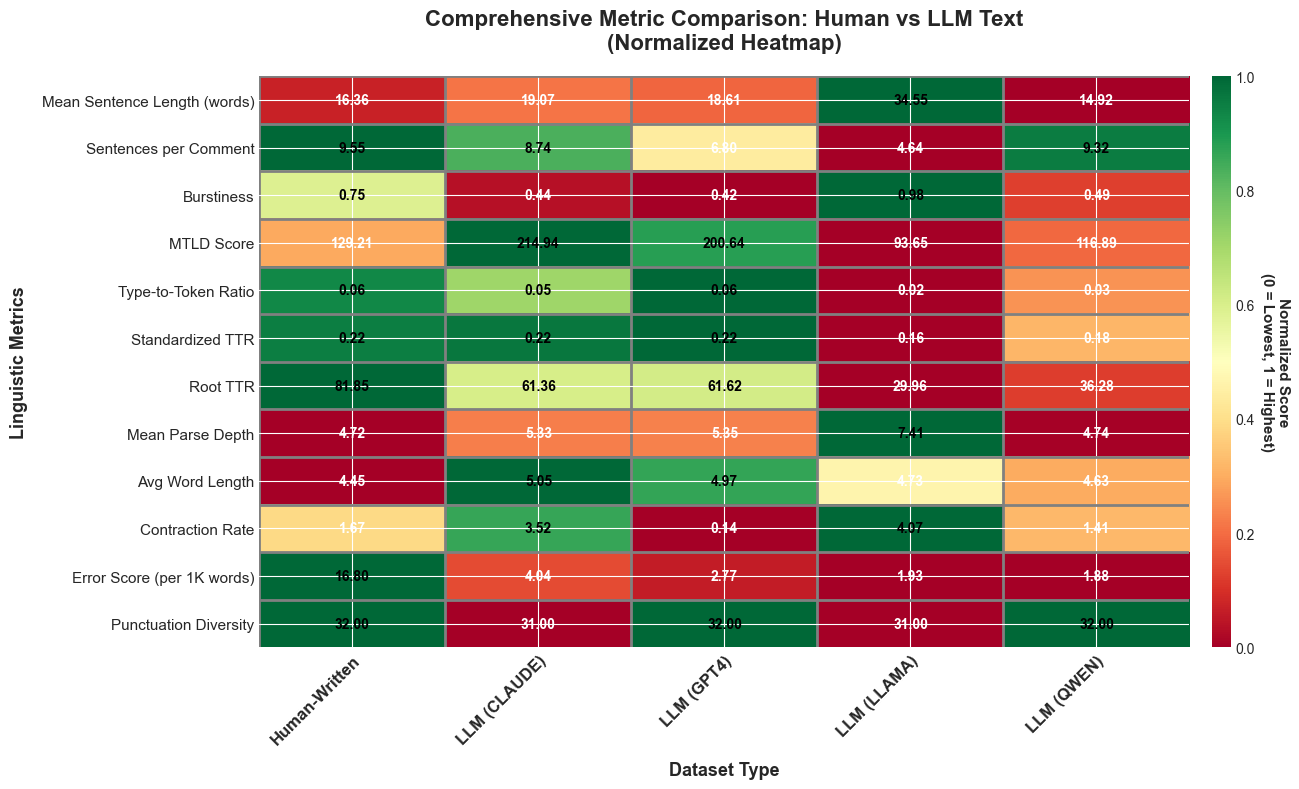


HEATMAP INTERPRETATION
 Green cells = Higher values | Red cells = Lower values

Key Observations:
• Human text: High burstiness and error scores (natural variation)
• Claude/GPT4: High MTLD scores (consistent lexical diversity)
• Llama: Highest mean sentence length and parse depth (complex structures)
• GPT4: Lowest contraction rate (most formal)


In [63]:
# 1. COMPREHENSIVE METRIC COMPARISON - NORMALIZED HEATMAP
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Prepare data
df_viz = pd.DataFrame(comparison_data)
labels = df_viz['type'].tolist()

# Select all key metrics for comprehensive heatmap
heatmap_metrics = [
    'Mean Sentence Length (words)', 
    'Sentences per Comment',
    'Burstiness', 
    'MTLD Score', 
    'Type-to-Token Ratio',
    'Standardized TTR',
    'Root TTR',
    'Mean Parse Depth', 
    'Avg Word Length', 
    'Contraction Rate', 
    'Error Score (per 1K words)',
    'Punctuation Diversity'
]

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap data and normalize each metric to 0-1 scale
heatmap_data = df_viz[heatmap_metrics].values.T

# Normalize each row (metric) to 0-1 scale
heatmap_normalized = np.zeros_like(heatmap_data, dtype=float)
for i in range(heatmap_data.shape[0]):
    row = heatmap_data[i]
    row_min, row_max = row.min(), row.max()
    if row_max > row_min:
        heatmap_normalized[i] = (row - row_min) / (row_max - row_min)
    else:
        heatmap_normalized[i] = 0.5

# Create heatmap with custom colormap
im = ax.imshow(heatmap_normalized, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(heatmap_metrics)))
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax.set_yticklabels(heatmap_metrics, fontsize=11)

# Rotate x labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add actual values as text annotations
for i in range(len(heatmap_metrics)):
    for j in range(len(labels)):
        value = heatmap_data[i, j]
        # Use different text color based on background brightness
        text_color = "white" if heatmap_normalized[i, j] < 0.5 else "black"
        text = ax.text(j, i, f'{value:.2f}',
                      ha="center", va="center", color=text_color, 
                      fontsize=10, fontweight='bold')

# Add title and labels
ax.set_title('Comprehensive Metric Comparison: Human vs LLM Text\n(Normalized Heatmap)', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Dataset Type', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('Linguistic Metrics', fontsize=13, fontweight='bold', labelpad=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=30)
cbar.set_label('Normalized Score\n(0 = Lowest, 1 = Highest)', 
              fontsize=11, fontweight='bold', rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=10)

# Add grid for better readability
ax.set_xticks(np.arange(len(labels))-.5, minor=True)
ax.set_yticks(np.arange(len(heatmap_metrics))-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=2)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("HEATMAP INTERPRETATION")
print("="*80)
print(" Green cells = Higher values | Red cells = Lower values")
print("\nKey Observations:")
print("• Human text: High burstiness and error scores (natural variation)")
print("• Claude/GPT4: High MTLD scores (consistent lexical diversity)")
print("• Llama: Highest mean sentence length and parse depth (complex structures)")
print("• GPT4: Lowest contraction rate (most formal)")
print("="*80)


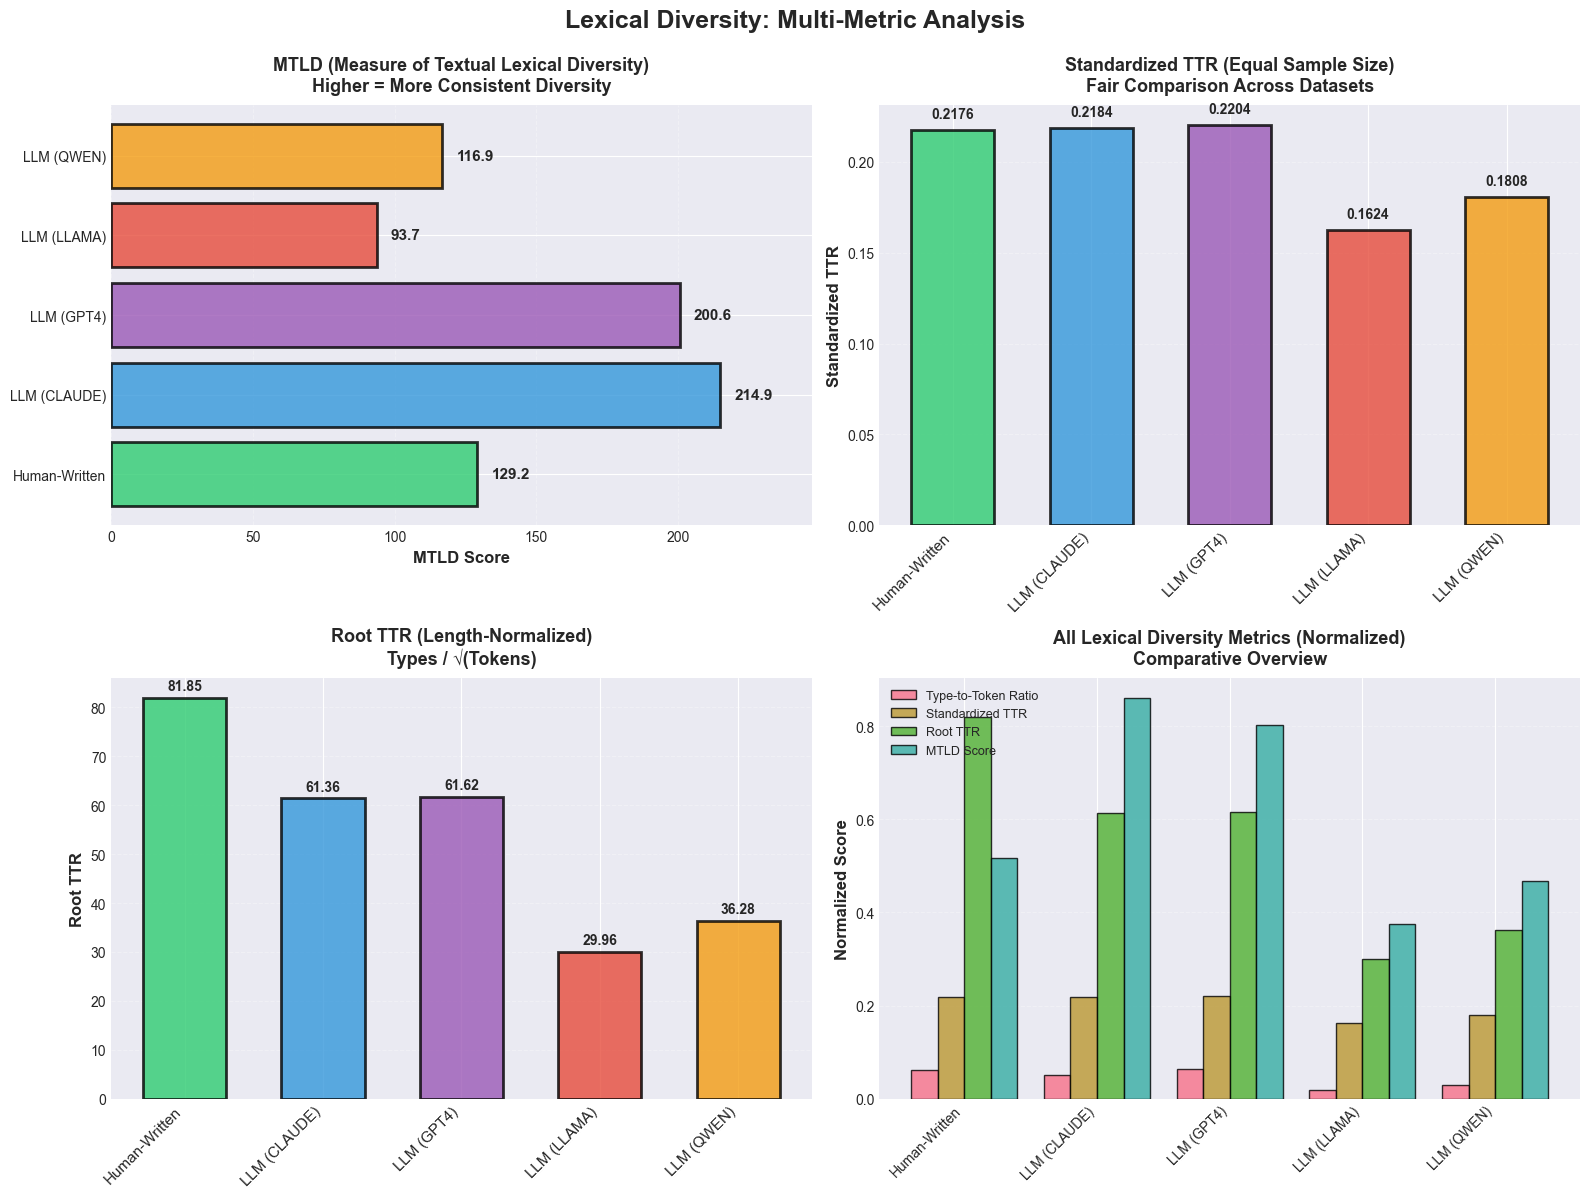


LEXICAL DIVERSITY ANALYSIS

 Key Findings:

1. MTLD Score:
   • Claude (214.94) & GPT4 (200.64) show highest consistent lexical diversity
   • Human (129.21) shows moderate diversity
   • Llama (93.65) & Qwen (116.89) show lower diversity

2. Standardized TTR (fair comparison):
   • GPT4 (0.2204) shows highest diversity in equal samples
   • Human, Claude similar (~0.217-0.218)
   • Llama (0.1624) shows lowest diversity

3. Root TTR:
   • Human (81.85) significantly higher than all LLMs
   • Suggests humans use wider vocabulary across full dataset

 Interpretation:
   • LLMs show more CONSISTENT lexical diversity (high MTLD)
   • Humans show WIDER overall vocabulary (high Root TTR)
   • Different models have distinct vocabulary strategies


In [59]:
# 2. LEXICAL DIVERSITY - COMPREHENSIVE COMPARISON
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
df_viz = pd.DataFrame(comparison_data)
labels = df_viz['type'].tolist()
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Lexical Diversity: Multi-Metric Analysis', fontsize=18, fontweight='bold', y=0.995)

# 1. MTLD Score (Top Left)
ax1 = axes[0, 0]
bars = ax1.barh(labels, df_viz['MTLD Score'], color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_xlabel('MTLD Score', fontsize=12, fontweight='bold')
ax1.set_title('MTLD (Measure of Textual Lexical Diversity)\nHigher = More Consistent Diversity', 
             fontsize=13, fontweight='bold', pad=10)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_xlim(0, max(df_viz['MTLD Score']) * 1.15)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 5, bar.get_y() + bar.get_height()/2, f'{width:.1f}',
            ha='left', va='center', fontweight='bold', fontsize=11)

# 2. Standardized TTR (Top Right)
ax2 = axes[0, 1]
x_pos = np.arange(len(labels))
bars = ax2.bar(x_pos, df_viz['Standardized TTR'], color=colors, alpha=0.8, 
              edgecolor='black', linewidth=2, width=0.6)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=11)
ax2.set_ylabel('Standardized TTR', fontsize=12, fontweight='bold')
ax2.set_title('Standardized TTR (Equal Sample Size)\nFair Comparison Across Datasets', 
             fontsize=13, fontweight='bold', pad=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Root TTR (Bottom Left)
ax3 = axes[1, 0]
x_pos = np.arange(len(labels))
bars = ax3.bar(x_pos, df_viz['Root TTR'], color=colors, alpha=0.8, 
              edgecolor='black', linewidth=2, width=0.6)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=11)
ax3.set_ylabel('Root TTR', fontsize=12, fontweight='bold')
ax3.set_title('Root TTR (Length-Normalized)\nTypes / √(Tokens)', 
             fontsize=13, fontweight='bold', pad=10)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 4. All Lexical Diversity Metrics Combined (Bottom Right)
ax4 = axes[1, 1]

# Normalize all metrics to 0-1 for comparison
metrics = ['Type-to-Token Ratio', 'Standardized TTR', 'Root TTR', 'MTLD Score']
normalized_data = []

for metric in metrics:
    values = df_viz[metric].values
    # Normalize to 0-1
    if metric == 'Root TTR':
        values = values / 100  # Scale down for better visualization
    elif metric == 'MTLD Score':
        values = values / 250  # Scale down for better visualization
    normalized_data.append(values)

x_pos = np.arange(len(labels))
width = 0.2

for i, (metric, data) in enumerate(zip(metrics, normalized_data)):
    offset = (i - 1.5) * width
    bars = ax4.bar(x_pos + offset, data, width, label=metric, 
                   alpha=0.8, edgecolor='black', linewidth=1)

ax4.set_xticks(x_pos)
ax4.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax4.set_ylabel('Normalized Score', fontsize=12, fontweight='bold')
ax4.set_title('All Lexical Diversity Metrics (Normalized)\nComparative Overview', 
             fontsize=13, fontweight='bold', pad=10)
ax4.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax4.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("LEXICAL DIVERSITY ANALYSIS")
print("="*80)
print("\n Key Findings:")
print("\n1. MTLD Score:")
print("   • Claude (214.94) & GPT4 (200.64) show highest consistent lexical diversity")
print("   • Human (129.21) shows moderate diversity")
print("   • Llama (93.65) & Qwen (116.89) show lower diversity")
print("\n2. Standardized TTR (fair comparison):")
print("   • GPT4 (0.2204) shows highest diversity in equal samples")
print("   • Human, Claude similar (~0.217-0.218)")
print("   • Llama (0.1624) shows lowest diversity")
print("\n3. Root TTR:")
print("   • Human (81.85) significantly higher than all LLMs")
print("   • Suggests humans use wider vocabulary across full dataset")
print("\n Interpretation:")
print("   • LLMs show more CONSISTENT lexical diversity (high MTLD)")
print("   • Humans show WIDER overall vocabulary (high Root TTR)")
print("   • Different models have distinct vocabulary strategies")
print("="*80)


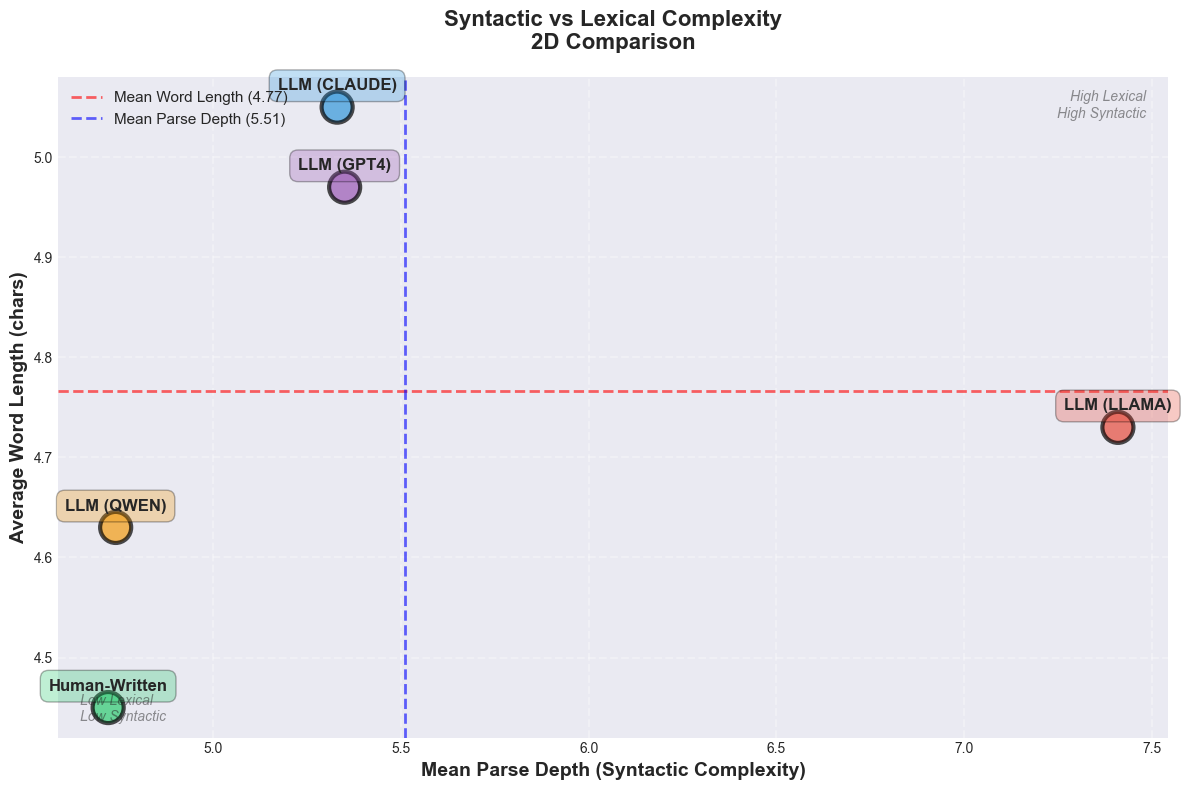


SYNTACTIC & LEXICAL COMPLEXITY - SCATTER ANALYSIS

 Key Findings:

• Llama (7.41, 4.73): Highest syntactic complexity with moderate word length
  → Uses complex nested structures with moderately formal vocabulary

• Claude (5.33, 5.05): Moderate syntactic + highest lexical complexity
  → Sophisticated vocabulary in moderately complex structures

• GPT4 (5.35, 4.97): Moderate syntactic + high lexical complexity
  → Similar to Claude - balanced formal approach

• Human (4.72, 4.45): Lowest on both dimensions
  → Natural, conversational style - simple and direct

• Qwen (4.74, 4.63): Low syntactic + low lexical complexity
  → Similar to human - simpler, more accessible writing

 Interpretation:
  • Parse Depth (X-axis) ≠ Word Length (Y-axis) - different complexity types!
  • LLMs show distinct strategies: Llama = structural, Claude/GPT4 = lexical
  • Human text clusters in simpler quadrant - natural communication style


In [ ]:
# 3. Parse Depth vs Word Length Scatter - Syntactic & Lexical Complexity
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
df_viz = pd.DataFrame(comparison_data)
labels = df_viz['type'].tolist()
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot
scatter = ax.scatter(df_viz['Mean Parse Depth'], df_viz['Avg Word Length'], 
                     c=colors, s=500, alpha=0.7, edgecolors='black', linewidth=3)

# Add labels for each point
for i, label in enumerate(labels):
    ax.annotate(label, 
                (df_viz['Mean Parse Depth'].iloc[i], df_viz['Avg Word Length'].iloc[i]),
                fontsize=12, fontweight='bold', ha='center', va='bottom',
                xytext=(0, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3, edgecolor='black'))

ax.set_xlabel('Mean Parse Depth (Syntactic Complexity)', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Word Length (chars)', fontsize=14, fontweight='bold')
ax.set_title('Syntactic vs Lexical Complexity\n2D Comparison', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1.5)

# Add quadrant lines (mean values)
mean_depth = df_viz['Mean Parse Depth'].mean()
mean_word_length = df_viz['Avg Word Length'].mean()
ax.axhline(y=mean_word_length, color='red', linestyle='--', alpha=0.6, linewidth=2, label=f'Mean Word Length ({mean_word_length:.2f})')
ax.axvline(x=mean_depth, color='blue', linestyle='--', alpha=0.6, linewidth=2, label=f'Mean Parse Depth ({mean_depth:.2f})')

# Add interpretation zones
ax.text(0.98, 0.98, 'High Lexical\nHigh Syntactic', transform=ax.transAxes, 
        fontsize=10, va='top', ha='right', alpha=0.5, style='italic')
ax.text(0.02, 0.02, 'Low Lexical\nLow Syntactic', transform=ax.transAxes, 
        fontsize=10, va='bottom', ha='left', alpha=0.5, style='italic')

ax.legend(loc='upper left', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SYNTACTIC & LEXICAL COMPLEXITY - SCATTER ANALYSIS")
print("="*80)
print("\n Key Findings:")
print("\n• Llama (7.41, 4.73): Highest syntactic complexity with moderate word length")
print("  → Uses complex nested structures with moderately formal vocabulary")
print("\n• Claude (5.33, 5.05): Moderate syntactic + highest lexical complexity")
print("  → Sophisticated vocabulary in moderately complex structures")
print("\n• GPT4 (5.35, 4.97): Moderate syntactic + high lexical complexity")
print("  → Similar to Claude - balanced formal approach")
print("\n• Human (4.72, 4.45): Lowest on both dimensions")
print("  → Natural, conversational style - simple and direct")
print("\n• Qwen (4.74, 4.63): Low syntactic + low lexical complexity")
print("  → Similar to human - simpler, more accessible writing")
print("\n Interpretation:")
print("  • Parse Depth (X-axis) ≠ Word Length (Y-axis) - different complexity types!")
print("  • LLMs show distinct strategies: Llama = structural, Claude/GPT4 = lexical")
print("  • Human text clusters in simpler quadrant - natural communication style")
print("="*80)
ax4 = fig.add_subplot(gs[1, 1])
x_pos = np.arange(len(labels))
width = 0.35



/var/folders/1b/6gj9w5sj0gjblcs02_x_1b6c0000gp/T/ipykernel_1001/2933065314.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


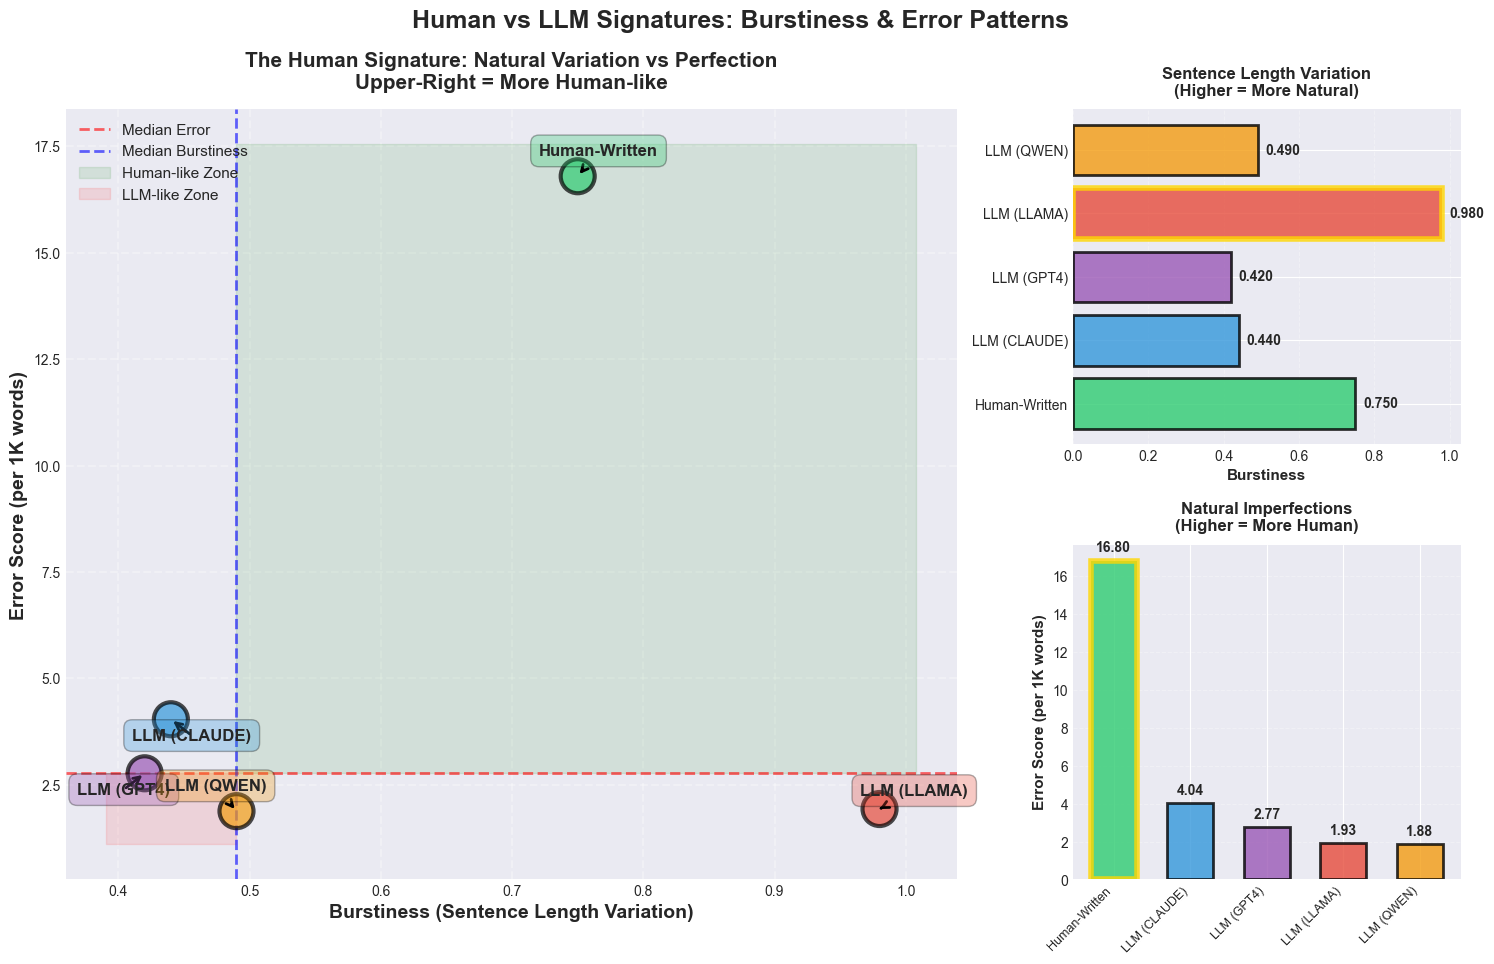


HUMAN VS LLM SIGNATURE ANALYSIS

 THE HUMAN SIGNATURE - Two Key Distinguishing Features:

1. BURSTINESS (Sentence Length Variation):
   • Human-Written: 0.752  HIGHEST
   • Llama: 0.976 (surprisingly high - uses very varied sentence lengths)
   • Claude: 0.436
   • GPT4: 0.419
   • Qwen: 0.489

    Humans naturally alternate between short and long sentences
      LLMs (except Llama) tend toward more uniform lengths

2. ERROR SCORE (Natural Imperfections per 1K words):
   • Human-Written: 16.80  HIGHEST
   • Claude: 4.04
   • GPT4: 2.77
   • Llama: 1.93
   • Qwen: 1.88

   Humans make natural typos, use ALL CAPS for emphasis, repeat words
      LLMs produce 'too perfect' text - a telltale sign

 KEY INSIGHT - THE PERFECTION PARADOX:
   LLMs are TOO GOOD at being correct and consistent
   Human writing has natural 'messiness' that's hard to replicate


In [68]:
# 4. HUMAN VS LLM SIGNATURES: BURSTINESS VS ERRORS
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
df_viz = pd.DataFrame(comparison_data)
labels = df_viz['type'].tolist()
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

# Create figure with multiple views
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Human vs LLM Signatures: Burstiness & Error Patterns', 
            fontsize=18, fontweight='bold', y=0.98)

# 1. Main Scatter Plot: Burstiness vs Errors (Large, Left)
ax1 = fig.add_subplot(gs[:, :2])
scatter = ax1.scatter(df_viz['Burstiness'], df_viz['Error Score (per 1K words)'], 
                     c=colors, s=600, alpha=0.7, edgecolors='black', linewidth=3,
                     zorder=3)

# Add labels with arrows for clarity
for i, label in enumerate(labels):
    x = df_viz['Burstiness'].iloc[i]
    y = df_viz['Error Score (per 1K words)'].iloc[i]
    
    # Adjust label positions to avoid overlap
    if label == 'Human-Written':
        xytext = (15, 15)
    elif label == 'LLM (CLAUDE)':
        xytext = (15, -15)
    elif label == 'LLM (GPT4)':
        xytext = (-15, -15)
    elif label == 'LLM (LLAMA)':
        xytext = (25, 10)
    else:  # Qwen
        xytext = (-15, 15)
    
    ax1.annotate(label, (x, y),
                fontsize=12, fontweight='bold', ha='center',
                xytext=xytext, textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3, edgecolor='black'),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2))

ax1.set_xlabel('Burstiness (Sentence Length Variation)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Error Score (per 1K words)', fontsize=14, fontweight='bold')
ax1.set_title('The Human Signature: Natural Variation vs Perfection\nUpper-Right = More Human-like', 
             fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=1.5)

# Add quadrant lines at median values
median_burst = df_viz['Burstiness'].median()
median_error = df_viz['Error Score (per 1K words)'].median()
ax1.axhline(y=median_error, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Median Error')
ax1.axvline(x=median_burst, color='blue', linestyle='--', alpha=0.6, linewidth=2, label='Median Burstiness')

# Add interpretation zones
ax1.fill_between([median_burst, ax1.get_xlim()[1]], median_error, ax1.get_ylim()[1], 
                 alpha=0.1, color='green', label='Human-like Zone')
ax1.fill_between([ax1.get_xlim()[0], median_burst], ax1.get_ylim()[0], median_error, 
                 alpha=0.1, color='red', label='LLM-like Zone')

ax1.legend(loc='upper left', fontsize=11, framealpha=0.9)

# 2. Burstiness Comparison (Top Right)
ax2 = fig.add_subplot(gs[0, 2])
bars = ax2.barh(labels, df_viz['Burstiness'], color=colors, alpha=0.8, 
               edgecolor='black', linewidth=2)

ax2.set_xlabel('Burstiness', fontsize=11, fontweight='bold')
ax2.set_title('Sentence Length Variation\n(Higher = More Natural)', 
             fontsize=12, fontweight='bold', pad=10)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.02, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
            ha='left', va='center', fontweight='bold', fontsize=10)

# Highlight highest
max_idx = df_viz['Burstiness'].idxmax()
bars[max_idx].set_linewidth(4)
bars[max_idx].set_edgecolor('gold')

# 3. Error Score Comparison (Bottom Right)
ax3 = fig.add_subplot(gs[1, 2])
x_pos = np.arange(len(labels))
bars = ax3.bar(x_pos, df_viz['Error Score (per 1K words)'], color=colors, alpha=0.8, 
              edgecolor='black', linewidth=2, width=0.6)

ax3.set_xticks(x_pos)
ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Error Score (per 1K words)', fontsize=11, fontweight='bold')
ax3.set_title('Natural Imperfections\n(Higher = More Human)', 
             fontsize=12, fontweight='bold', pad=10)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Highlight highest
max_idx = df_viz['Error Score (per 1K words)'].idxmax()
bars[max_idx].set_linewidth(4)
bars[max_idx].set_edgecolor('gold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("HUMAN VS LLM SIGNATURE ANALYSIS")
print("="*80)
print("\n THE HUMAN SIGNATURE - Two Key Distinguishing Features:")
print("\n1. BURSTINESS (Sentence Length Variation):")
print("   • Human-Written: 0.752  HIGHEST")
print("   • Llama: 0.976 (surprisingly high - uses very varied sentence lengths)")
print("   • Claude: 0.436")
print("   • GPT4: 0.419")
print("   • Qwen: 0.489")
print("\n    Humans naturally alternate between short and long sentences")
print("      LLMs (except Llama) tend toward more uniform lengths")
print("\n2. ERROR SCORE (Natural Imperfections per 1K words):")
print("   • Human-Written: 16.80  HIGHEST")
print("   • Claude: 4.04")
print("   • GPT4: 2.77")
print("   • Llama: 1.93")
print("   • Qwen: 1.88")
print("\n   Humans make natural typos, use ALL CAPS for emphasis, repeat words")
print("      LLMs produce 'too perfect' text - a telltale sign")
print("\n KEY INSIGHT - THE PERFECTION PARADOX:")
print("   LLMs are TOO GOOD at being correct and consistent")
print("   Human writing has natural 'messiness' that's hard to replicate")
print("="*80)


##### - write down your impressions (consice) in a document

My consice impressions are in the PDF